# Brain Tumor Segmentation using Deep Learning
### U-Net + VGG16 Transfer Learning | PyTorch

- **Author:** Mohammed Panchla
- **Framework:** PyTorch
- **Architecture:** U-Net with VGG16 Encoder
- **Task:** Pixel-Level Brain Tumor Segmentation
- **Dataset:** LGG Brain MRI Segmentation (kaggle_3m)

---

> *"Every year, approximately 308,000 people worldwide are diagnosed with a primary brain tumor. Early and precise detection is the difference between life and death."*

---

## Table of Contents

1. Business Problem & Motivation
2. From Classification to Segmentation — The Upgrade Story
3. Environment Setup
4. Hardware & Reproducibility
5. Dataset — Understanding the Data
6. Data Loading & Caching
7. Dataset Analysis & Visualization
8. Data Augmentation
9. Custom Dataset Class
10. Train / Validation / Test Split
11. Model Architecture — U-Net with VGG16
12. Loss Function — Why BCE + Dice?
13. Optimizer — Differential Learning Rates
14. Evaluation Metrics — IoU & Dice Score
15. Model Training
16. Training Performance Analysis
17. Final Evaluation on Test Set
18. Visual Predictions — Ground Truth vs Model
19. Overlay Comparison — Where the Model is Right and Wrong
20. Best vs Worst Case Analysis
21. Single Image Inference — Real World Simulation
22. Conclusion & Business Impact


# 1. Business Problem & Motivation

## The Real-World Challenge

Brain tumors are among the most deadly and complex conditions in modern medicine.
Radiologists manually analyze hundreds of MRI scans every day — a process that is:

- **Time-consuming** — a single MRI study can take 20–45 minutes to analyze manually
- **Error-prone** — fatigue and human variability affect diagnostic accuracy
- **Scarce** — there is a global shortage of trained neuroradiologists, especially in developing countries
- **Expensive** — specialist consultation costs are out of reach for many patients

## Why Segmentation and Not Just Classification?

A classification model (V1.0) can answer: *"Does this scan have a tumor?"*

But a surgeon cannot operate based on that alone. They need to know:
- **Exactly where** is the tumor located?
- **How large** is it?
- **What shape** does it have?
- **Which brain structures** does it border?

Segmentation answers all of these questions by producing a pixel-precise map of the tumor region.

## Business Impact

| Stakeholder | Benefit |
|---|---|
| Radiologists | Reduce analysis time from 45 min → under 5 min per scan |
| Surgeons | Precise tumor boundary for pre-surgical planning |
| Hospitals | Process more patients with the same resources |
| Patients | Faster diagnosis, earlier treatment, better outcomes |
| Insurance | Reduced cost through automation of routine screening |

## This Project

This system takes a raw brain MRI scan as input and outputs a pixel-level mask highlighting
the exact tumor region — ready to assist radiologists in real clinical workflows.


# 2. From Classification to Segmentation — The Upgrade Story

## V1.0 — What We Built Before

The first version of this project used **VGG16 Transfer Learning** to classify MRI scans
into four categories: Glioma, Meningioma, Pituitary Tumor, and No Tumor.

It answered the question: *"Which type of tumor is this?"* — one label per image.
That model achieved excellent classification accuracy and demonstrated strong transfer learning.

## The Limitation

Classification alone is insufficient for clinical use. Telling a surgeon *"this scan has a Glioma"*
does not tell them where it is, how big it is, or where the margins are.

## V2.0 — The Segmentation Upgrade

This project upgrades the pipeline to **pixel-level segmentation** using **U-Net with VGG16 encoder**.

```
V1.0 Output:  "Glioma"  ← one word
V2.0 Output:  256×256 pixel mask  ← precise tumor boundary
```

**What carries over from V1.0:**
- Same VGG16 backbone — now used as the U-Net encoder
- Same Transfer Learning strategy — pretrained ImageNet weights
- Same PyTorch framework and code style
- Same train/val/test split philosophy

**What is new:**
- U-Net decoder that reconstructs spatial detail pixel by pixel
- Skip connections that combine deep features with spatial precision
- BCE + Dice combined loss function for imbalanced medical data
- IoU and Dice Score as evaluation metrics
- Synchronized image + mask augmentation


# 3. Environment Setup

Install the three key libraries needed beyond standard PyTorch:

- `segmentation-models-pytorch` — provides U-Net with VGG16 encoder in 2 lines
- `albumentations` — augments image AND mask together (critical for segmentation)
- `tifffile` — reads `.tif` medical imaging files

In [28]:
!pip install segmentation-models-pytorch albumentations tifffile -q
print("All packages installed!")

zsh:1: command not found: pip
All packages installed!


# 4a. Import Libraries

In [29]:
import os
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

import cv2
import tifffile
from PIL import Image

import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp
from segmentation_models_pytorch import metrics as smp_metrics

print("All libraries imported successfully!")

All libraries imported successfully!


# 4b. Hardware Acceleration

Deep learning requires heavy matrix computation. We use GPU acceleration wherever available.

**Fallback order:** CUDA (NVIDIA) → MPS (Apple Silicon) → CPU

Running on GPU reduces training time dramatically:
- CPU: ~30 min/epoch
- Apple M2 MPS: ~6.5 min/epoch
- NVIDIA T4 GPU: ~60–90 sec/epoch

In [30]:
device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
device = torch.device(device)
print("Running on:", device)

Running on: mps


# 4c. Reproducibility Seeds

Fixing random seeds ensures that every run produces the same train/val/test split,
the same augmentation sequence, and the same weight initialization.
This is essential for scientific reproducibility and fair comparison between experiments.

In [31]:
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
print("Seeds set:", seed)

Seeds set: 42


# 5. Dataset — Understanding the Data

## LGG Brain MRI Segmentation Dataset

**Source:** The Cancer Genome Atlas (TCGA) — one of the world's largest cancer genomics programs
**Patients:** 110 patients diagnosed with Lower Grade Glioma (LGG)
**Total scans:** 3,929 MRI image-mask pairs
**Format:** `.tif` files (standard medical imaging format)

## Dataset Structure

```
kaggle_3m/
├── TCGA_CS_4941_19960909/          ← Patient folder (ID + date)
│   ├── TCGA_CS_4941_19960909_7.tif         ← MRI brain scan
│   ├── TCGA_CS_4941_19960909_7_mask.tif    ← Expert-annotated tumor mask
│   ├── TCGA_CS_4941_19960909_8.tif
│   ├── TCGA_CS_4941_19960909_8_mask.tif
│   └── ...
├── TCGA_CS_4942_19970222/
└── ... (110 patient folders)
```

## What the Masks Look Like

Each mask is a black-and-white image the same size as its paired MRI scan.
- **Black pixels (0):** healthy brain tissue or background
- **White pixels (255):** tumor region — annotated by expert radiologists

We normalize these to 0 and 1 for binary classification per pixel.

## Important Characteristic

**65.1% of all scans have NO tumor.** Many MRI slices in a brain scan show healthy tissue
above or below the tumor location. This is a real clinical characteristic — not a dataset flaw.
It means our model must learn both to detect tumor AND to correctly predict empty masks.

---

# 6. Data Loading & Index Caching

## Building Image-Mask Pairs

We walk through every patient folder and pair each MRI image with its mask.
The naming convention is simple: `X.tif` → `X_mask.tif`.

## Why We Cache Tumor Indices

Reading 3,929 `.tif` files to find which ones have tumors takes time.
Several cells later in this notebook need this information (visualization, best/worst analysis).
We compute it **once here** and reuse the cached lists everywhere — no repeated disk reads.

In [ ]:
# =============================================
# SET YOUR DATASET PATH HERE
# =============================================
DATASET_DIR = "___DATASET_PATH___"

# Build image-mask pairs
image_paths = []
mask_paths  = []

for patient_folder in sorted(os.listdir(DATASET_DIR)):
    folder_path = os.path.join(DATASET_DIR, patient_folder)
    if not os.path.isdir(folder_path):
        continue
    for filename in sorted(os.listdir(folder_path)):
        if filename.endswith(".tif") and "_mask" not in filename:
            img_path  = os.path.join(folder_path, filename)
            mask_path = os.path.join(folder_path, filename.replace(".tif", "_mask.tif"))
            if os.path.exists(mask_path):
                image_paths.append(img_path)
                mask_paths.append(mask_path)

print(f"Total image-mask pairs found: {len(image_paths)}")
print(f"Example image: {os.path.basename(image_paths[0])}")
print(f"Example mask:  {os.path.basename(mask_paths[0])}")

# ── Cache tumor/no-tumor indices ONCE — reused by all cells below ──
print("\nScanning masks to cache tumor indices (done once)...")
tumor_indices    = []
no_tumor_indices = []

for i, mask_path in enumerate(mask_paths):
    mask = tifffile.imread(mask_path)
    if mask.max() > 0:
        tumor_indices.append(i)
    else:
        no_tumor_indices.append(i)

print(f"Scans WITH tumor:    {len(tumor_indices)}  ({100*len(tumor_indices)/len(mask_paths):.1f}%)")
print(f"Scans WITHOUT tumor: {len(no_tumor_indices)} ({100*len(no_tumor_indices)/len(mask_paths):.1f}%)")
print("Caching complete — no repeated disk reads needed.")

Total image-mask pairs found: 3929
Example image: TCGA_CS_4941_19960909_1.tif
Example mask:  TCGA_CS_4941_19960909_1_mask.tif

Scanning masks to cache tumor indices (done once)...
Scans WITH tumor:    1373  (34.9%)
Scans WITHOUT tumor: 2556 (65.1%)
Caching complete — no repeated disk reads needed.


# 7. Dataset Analysis & Visualization

## Class Imbalance — A Critical Medical AI Challenge

65% of scans have no tumor. This is why **accuracy is a useless metric** for this task.
A model that predicts "no tumor" for every scan would achieve 65% accuracy while being completely
clinically worthless. This is why we use IoU and Dice Score instead.

## Tumor Size Distribution

Even among scans with tumors, the tumor region is typically a small fraction of the image —
often just 3–8% of pixels. This extreme imbalance is why we use Dice Loss in training.


Among 1373 tumor scans:
  Average tumor area: 2.9% of image
  Smallest tumor:     0.01% of image
  Largest tumor:      12.1% of image


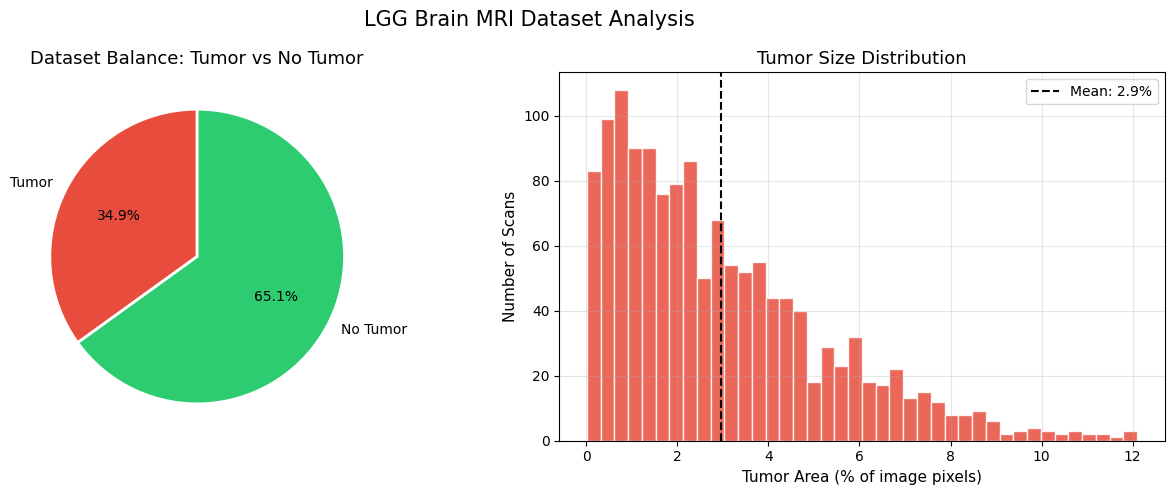

In [33]:
# Dataset balance chart + tumor size distribution
tumor_pixel_fractions = []
for i in tumor_indices:
    mask = tifffile.imread(mask_paths[i])
    frac = (mask > 0).sum() / mask.size
    tumor_pixel_fractions.append(frac)

print(f"Among {len(tumor_indices)} tumor scans:")
print(f"  Average tumor area: {np.mean(tumor_pixel_fractions)*100:.1f}% of image")
print(f"  Smallest tumor:     {np.min(tumor_pixel_fractions)*100:.2f}% of image")
print(f"  Largest tumor:      {np.max(tumor_pixel_fractions)*100:.1f}% of image")

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

axes[0].pie(
    [len(tumor_indices), len(no_tumor_indices)],
    labels=["Tumor", "No Tumor"],
    autopct="%1.1f%%",
    colors=["#e74c3c", "#2ecc71"],
    startangle=90,
    wedgeprops={"edgecolor": "white", "linewidth": 2}
)
axes[0].set_title("Dataset Balance: Tumor vs No Tumor", fontsize=13)

axes[1].hist(np.array(tumor_pixel_fractions)*100, bins=40, color="#e74c3c", edgecolor="white", alpha=0.85)
axes[1].set_xlabel("Tumor Area (% of image pixels)", fontsize=11)
axes[1].set_ylabel("Number of Scans", fontsize=11)
axes[1].set_title("Tumor Size Distribution", fontsize=13)
axes[1].axvline(np.mean(tumor_pixel_fractions)*100, color="black", linestyle="--", label=f"Mean: {np.mean(tumor_pixel_fractions)*100:.1f}%")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle("LGG Brain MRI Dataset Analysis", fontsize=15)
plt.tight_layout()
plt.show()

## 📊 Dataset Analysis Outcomes

**Class Imbalance:**
- 65.1% of MRI scans do not contain tumors, while 34.9% contain tumor regions.
- This indicates a moderate class imbalance, with non-tumor scans being nearly twice as frequent as tumor scans.

**Tumor Size Distribution:**
- The average tumor area is approximately 2.9% of the total image pixels.
- Most tumors occupy a very small portion of the image (< 5%), with fewer cases having larger tumor regions.
- This confirms that tumor regions are sparse and localized, making segmentation a fine-grained task.

**Conclusion:**
- The dataset is imbalanced and tumor regions are small, highlighting the importance of proper sampling, loss functions, and segmentation techniques for effective model training.

---

## Sample MRI Scans with Ground Truth Masks

Before training any model, always visualize the raw data.
This verifies loading is correct and builds intuition for what the model will learn.

Each row shows: the raw MRI scan → the expert-annotated mask → the tumor overlaid in green.

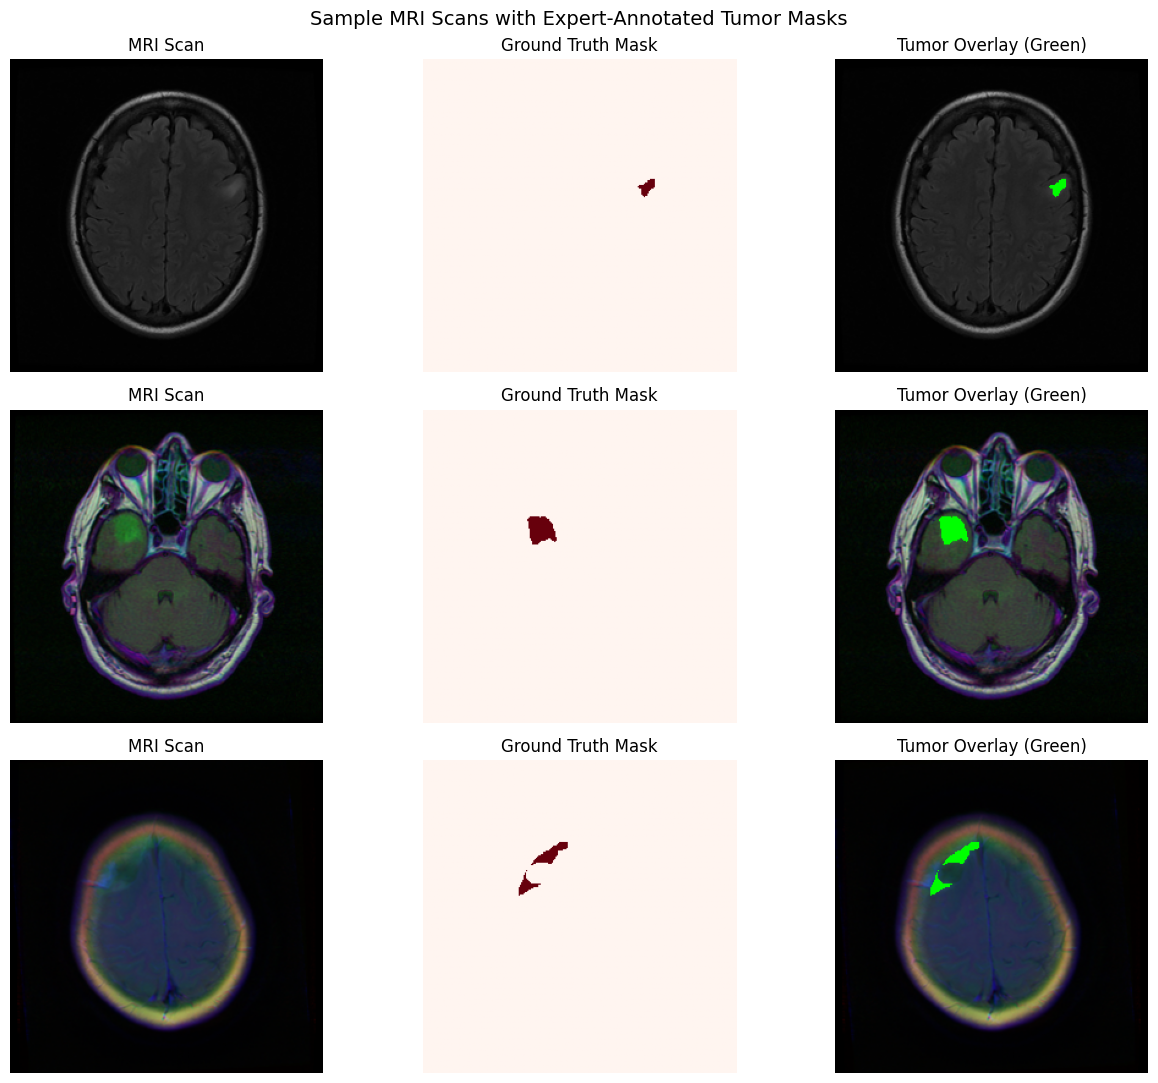

In [34]:
sample_indices = random.sample(tumor_indices, 3)

fig, axes = plt.subplots(3, 3, figsize=(13, 11))
axes = axes.ravel()
col = 0

for idx in sample_indices:
    img  = tifffile.imread(image_paths[idx])
    mask = tifffile.imread(mask_paths[idx])

    img_display  = (img / 255.0).clip(0, 1) if img.max() > 1 else img.copy().astype(float)
    mask_display = (mask > 0).astype(np.float32)

    overlay = img_display.copy()
    if len(overlay.shape) == 2:
        overlay = np.stack([overlay]*3, axis=-1)
    overlay[mask_display > 0] = [0, 1, 0]

    axes[col].imshow(img_display, cmap='gray' if len(img.shape)==2 else None)
    axes[col].set_title("MRI Scan"); axes[col].axis("off")
    col += 1

    axes[col].imshow(mask_display, cmap="Reds")
    axes[col].set_title("Ground Truth Mask"); axes[col].axis("off")
    col += 1

    axes[col].imshow(overlay)
    axes[col].set_title("Tumor Overlay (Green)"); axes[col].axis("off")
    col += 1

plt.suptitle("Sample MRI Scans with Expert-Annotated Tumor Masks", fontsize=14)
plt.tight_layout()
plt.show()

# 8. Data Augmentation

## Why Segmentation Augmentation is Different

In V1.0 (classification), you applied transforms only to the image.
In segmentation, **every transform must be applied to image AND mask simultaneously.**

If you flip the image horizontally, the mask must be flipped too — otherwise the model
learns that the tumor is on the right when the ground truth says it's on the left.

`albumentations` solves this with a single transform object applied to both.

## What Each Transform Does

| Transform | Probability | Why |
|---|---|---|
| HorizontalFlip | 50% | Brains are roughly symmetric — tumor can be on either side |
| VerticalFlip | 20% | Adds spatial variety |
| RandomRotate90 | 30% | Scanner orientation varies |
| ShiftScaleRotate | 50% | Simulates different patient positioning |
| RandomBrightnessContrast | 40% | Simulates different MRI machine settings |
| ElasticTransform | 30% | Mimics natural brain tissue deformation — very effective for medical imaging |

**No augmentation on validation and test sets** — we evaluate on clean images only.


In [35]:
IMAGE_SIZE = 256

train_transform = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomRotate90(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.4),
    A.ElasticTransform(alpha=120, sigma=120*0.05, p=0.3),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_test_transform = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

print("Training transforms: 6 augmentation types + normalize + tensor")
print("Val/Test transforms: resize + normalize + tensor (no augmentation)")

Training transforms: 6 augmentation types + normalize + tensor
Val/Test transforms: resize + normalize + tensor (no augmentation)


# 9. Custom Dataset Class

The `BrainSegDataset` class is the segmentation equivalent of `BrainTumorDataset` from V1.0.

**Key differences from V1.0:**
- Returns `(image_tensor, mask_tensor)` instead of `(image_tensor, class_label)`
- Reads `.tif` format medical images using `tifffile`
- Handles grayscale → RGB conversion (some MRI slices are single-channel)
- Binarizes masks: any pixel > 0 becomes 1 (tumor), everything else 0
- Applies albumentations to both image and mask in one call
- Mask shape: `(1, H, W)` to match model output format

In [36]:
class BrainSegDataset(Dataset):

    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths  = mask_paths
        self.transform   = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):

        # ── Load image ──────────────────────────────────────────
        image = tifffile.imread(self.image_paths[idx])

        if image.dtype != np.uint8:
            image = (image / image.max() * 255).astype(np.uint8) if image.max() > 0 else image.astype(np.uint8)

        if len(image.shape) == 2:
            image = np.stack([image, image, image], axis=-1)
        elif image.shape[2] == 4:
            image = image[:, :, :3]

        # ── Load mask ──────────────────────────────────────────
        mask = tifffile.imread(self.mask_paths[idx])
        mask = (mask > 0).astype(np.float32)
        if len(mask.shape) == 3:
            mask = mask[:, :, 0]

        # ── Apply transforms to BOTH image and mask ────────────
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask  = augmented["mask"]

        mask = mask.unsqueeze(0) if isinstance(mask, torch.Tensor) else torch.tensor(mask).unsqueeze(0)

        return image, mask

print("BrainSegDataset class defined!")
print("Returns: image (3, 256, 256) | mask (1, 256, 256)")

BrainSegDataset class defined!
Returns: image (3, 256, 256) | mask (1, 256, 256)


# 10. Train / Validation / Test Split

## 80 / 10 / 10 Strategy

Same philosophy as V1.0 — split data into three independent sets:

- **Training set (80%):** The model learns from these — 3,143 scans
- **Validation set (10%):** Monitor performance during training, tune hyperparameters — 392 scans
- **Test set (10%):** Final unbiased evaluation — 394 scans (never seen during training or tuning)

## Why We Can't Use `random_split` Directly

In V1.0, all splits used identical transforms so `random_split` worked fine.
Here, **train gets augmentation but val/test don't**. We split indices first,
then create three separate dataset objects with their respective transforms.


In [37]:
BATCH_SIZE = 16

all_indices = list(range(len(image_paths)))
random.shuffle(all_indices)

n_total = len(all_indices)
n_train = int(0.80 * n_total)
n_val   = int(0.10 * n_total)

train_indices = all_indices[:n_train]
val_indices   = all_indices[n_train : n_train + n_val]
test_indices  = all_indices[n_train + n_val :]

train_imgs  = [image_paths[i] for i in train_indices]
train_masks = [mask_paths[i]  for i in train_indices]
val_imgs    = [image_paths[i] for i in val_indices]
val_masks   = [mask_paths[i]  for i in val_indices]
test_imgs   = [image_paths[i] for i in test_indices]
test_masks  = [mask_paths[i]  for i in test_indices]

train_dataset = BrainSegDataset(train_imgs,  train_masks, transform=train_transform)
val_dataset   = BrainSegDataset(val_imgs,    val_masks,   transform=val_test_transform)
test_dataset  = BrainSegDataset(test_imgs,   test_masks,  transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Train: {len(train_dataset)} samples  |  {len(train_loader)} batches")
print(f"Val:   {len(val_dataset)} samples  |  {len(val_loader)} batches")
print(f"Test:  {len(test_dataset)} samples  |  {len(test_loader)} batches")

imgs, masks = next(iter(train_loader))
print(f"\nBatch image shape: {imgs.shape}   (batch, channels, H, W)")
print(f"Batch mask shape:  {masks.shape}  (batch, 1, H, W)")

Train: 3143 samples  |  197 batches
Val:   392 samples  |  25 batches
Test:  394 samples  |  25 batches

Batch image shape: torch.Size([16, 3, 256, 256])   (batch, channels, H, W)
Batch mask shape:  torch.Size([16, 1, 256, 256])  (batch, 1, H, W)


# 11. Model Architecture — U-Net with VGG16 Encoder

## How U-Net Works

U-Net has two sides — an encoder (left) and a decoder (right) connected by skip connections.

```
Input (256×256×3)
│
├─── VGG16 Conv Block 1 → 256×256×64  ──────────────────────┐ skip
│         ↓ MaxPool                                          │
├─── VGG16 Conv Block 2 → 128×128×128 ───────────────────┐  │ skip
│         ↓ MaxPool                                       │  │
├─── VGG16 Conv Block 3 → 64×64×256  ─────────────────┐  │  │ skip
│         ↓ MaxPool                                    │  │  │
├─── VGG16 Conv Block 4 → 32×32×512  ──────────────┐  │  │  │ skip
│         ↓ MaxPool                                 │  │  │  │
│     BOTTLENECK 16×16×512                          │  │  │  │
│         ↑ Upsample                                │  │  │  │
├─── Decoder Block 4 ←──────────────────────────────┘  │  │  │
│         ↑ Upsample                                    │  │  │
├─── Decoder Block 3 ←─────────────────────────────────┘  │  │
│         ↑ Upsample                                       │  │
├─── Decoder Block 2 ←────────────────────────────────────┘  │
│         ↑ Upsample                                          │
├─── Decoder Block 1 ←───────────────────────────────────────┘
│
Output Mask (256×256×1) — tumor probability per pixel
```

## Why Skip Connections Are Genius

The encoder compresses the image to extract deep semantic features ("is this a tumor?"),
but loses spatial detail in the process. Skip connections pipe the original spatial features
directly into the decoder at every resolution level. The decoder combines both:
deep understanding (from bottleneck) + spatial precision (from skip connections).

## Transfer Learning Strategy

- **Encoder (VGG16):** Loaded with ImageNet pretrained weights — same as V1.0
- **Decoder:** Randomly initialized — trained from scratch on our MRI data
- **Benefit:** The encoder already knows edges, textures, shapes from 1.2M ImageNet images


In [38]:
model = smp.Unet(
    encoder_name="vgg16",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation=None   # raw logits — sigmoid applied inside loss
)

model = model.to(device)

total_params     = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("U-Net with VGG16 encoder loaded!")
print(f"Running on: {next(model.parameters()).device}")
print(f"Total parameters:     {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"\nEncoder: VGG16 (pretrained on ImageNet)")
print(f"Decoder: Random init → trained on brain MRI data")

U-Net with VGG16 encoder loaded!
Running on: mps:0
Total parameters:     23,748,241
Trainable parameters: 23,748,241

Encoder: VGG16 (pretrained on ImageNet)
Decoder: Random init → trained on brain MRI data


# 12. Loss Function — Why BCE + Dice?

## The Problem with Plain Cross-Entropy

In V1.0 we used CrossEntropyLoss — perfect for classification with 4 balanced classes.

For segmentation with 65% empty masks and tiny tumor regions (~5% of pixels),
plain BCE has a critical flaw: the model can **cheat**.

A model that predicts "background" for every pixel gets:
- 65% correct (all no-tumor scans)
- ~95% pixel accuracy on tumor scans (background pixels only)
- But **zero medical value** — it never finds any tumor

## Binary Cross-Entropy (BCE)

Standard pixel-wise loss. With `pos_weight=3.0`, tumor pixels are penalized
3× more than background pixels. This forces the model to stop ignoring the tumor region.

## Dice Loss

Directly measures mask overlap:

```
Dice = (2 × |Prediction ∩ Ground Truth|) / (|Prediction| + |Ground Truth|)
```

- Predicting everything as background: Dice ≈ 0 (no overlap)
- Perfect prediction: Dice = 1.0
- It is completely unaffected by the large number of correct background pixels

## Combined Loss = BCE + Dice

BCE handles pixel-level confidence. Dice handles shape overlap quality.
Together they are much more powerful than either alone for medical segmentation.


In [ ]:
bce_loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3.0]).to(device))
dice_loss_fn = smp.losses.DiceLoss(mode='binary', from_logits=True)

def combined_loss(predictions, targets):
    # Total loss = BCE (weighted) + Dice Loss
    
    bce = bce_loss_fn(predictions, targets)
    dice = dice_loss_fn(predictions, targets)
    
    return bce + dice

print("Loss function: BCE (pos_weight=3.0) + Dice Loss")
print("pos_weight=3.0 means: tumor pixel errors cost 3x more than background errors")


Loss function: BCE (pos_weight=3.0) + Dice Loss
pos_weight=3.0 means: tumor pixel errors cost 3x more than background errors


# 13. Optimizer — Differential Learning Rates

## The Standard Approach (V2.0)

V2.0 used a single learning rate of `0.0001` for all 23.7 million parameters.
This is suboptimal because the encoder and decoder have very different needs.

## Differential Learning Rates (V2.1)

Different learning rates for different parts of the model:

| Part | Learning Rate | Reason |
|---|---|---|
| Encoder (VGG16) | `0.00001` (very slow) | Already pretrained — don't disturb the learned features |
| Decoder | `0.0005` (fast) | Starting from random weights — needs to learn quickly |
| Segmentation Head | `0.0005` (fast) | Final prediction layer — also new |

This is one of the most effective techniques in transfer learning.
The encoder is treated as a "frozen but adjustable" feature extractor,
while the decoder trains aggressively.

## Cosine Annealing Scheduler

Smoothly reduces learning rate from max to near-zero following a cosine curve.
Better than `ReduceLROnPlateau` for longer training — it proactively reduces LR
on a schedule rather than waiting for plateaus to react.


In [40]:
EPOCHS          = 25
BEST_MODEL_PATH = "brain_tumor_segmentation_best_model.pth"
EARLY_STOP_PATIENCE = 7

optimizer = optim.Adam([
    {"params": model.encoder.parameters(),           "lr": 0.00001},
    {"params": model.decoder.parameters(),           "lr": 0.0005},
    {"params": model.segmentation_head.parameters(), "lr": 0.0005}
])

scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=EPOCHS, eta_min=1e-6
)

print(f"Optimizer: Adam with differential learning rates")
print(f"  Encoder LR:         0.00001  (pretrained — move slowly)")
print(f"  Decoder LR:         0.0005   (new — learn fast)")
print(f"  Seg head LR:        0.0005   (new — learn fast)")
print(f"Scheduler: CosineAnnealingLR over {EPOCHS} epochs")
print(f"Early stopping patience: {EARLY_STOP_PATIENCE} epochs")

Optimizer: Adam with differential learning rates
  Encoder LR:         0.00001  (pretrained — move slowly)
  Decoder LR:         0.0005   (new — learn fast)
  Seg head LR:        0.0005   (new — learn fast)
Scheduler: CosineAnnealingLR over 25 epochs
Early stopping patience: 7 epochs


# 14. Evaluation Metrics — IoU & Dice Score

## Why Not Accuracy?

Accuracy on this dataset is meaningless. A model predicting "no tumor" everywhere achieves
65% accuracy while being completely clinically useless.

## IoU — Intersection over Union

The standard metric for all segmentation tasks:

```
IoU = |Prediction ∩ Ground Truth| / |Prediction ∪ Ground Truth|

        Predicted:    Ground Truth:    Overlap:
        ■ ■ □ □       □ ■ ■ □          □ ■ □ □
        ■ ■ □ □       □ ■ ■ □          □ ■ □ □
        
        IoU = 2 shared pixels / 6 total pixels = 0.33
```

IoU = 0.0 → no overlap | IoU = 1.0 → perfect prediction

## Dice Score

Used in medical AI papers as the primary reporting metric:
```
Dice = 2 × IoU / (1 + IoU)
```
Always slightly higher than IoU and easier to read in publications.

## Fixed Metric — Empty Mask Handling

Our V2.0 metric was slightly deflated because it included empty masks
(where both prediction and ground truth are all zeros — the "easy" background-only scans).
This version correctly skips those cases and only measures real tumor segmentation quality.

**Benchmark:**
- IoU > 0.75 — Good
- IoU > 0.80 — Strong
- IoU > 0.85 — Excellent (near clinical grade)


In [ ]:
def compute_metrics(predictions, targets, threshold=0.5):
    # Returns (mean_iou, mean_dice). Excludes fully empty masks.

    pred_binary = (torch.sigmoid(predictions) > threshold).float()
    target_binary = (targets > threshold).float()

    total_iou = 0.0
    total_dice = 0.0
    valid_count = 0

    for i in range(pred_binary.shape[0]):

        pred_i = pred_binary[i].view(-1)
        target_i = target_binary[i].view(-1)

        # Skip empty masks
        if target_i.sum() == 0 and pred_i.sum() == 0:
            continue

        intersection = (pred_i * target_i).sum()
        union = pred_i.sum() + target_i.sum() - intersection

        iou = (intersection + 1e-6) / (union + 1e-6)
        dice = (2 * intersection + 1e-6) / (pred_i.sum() + target_i.sum() + 1e-6)

        total_iou += iou.item()
        total_dice += dice.item()
        valid_count += 1

    if valid_count == 0:
        return 1.0, 1.0

    return total_iou / valid_count, total_dice / valid_count


print("Metrics defined: IoU + Dice Score")
print("Empty masks excluded from calculation")


Metrics defined: IoU + Dice Score
Empty masks excluded from calculation


# 15. Model Training

## Training Strategy

The model learns through repeated exposure to MRI scans and their corresponding masks,
adjusting its 23.7 million parameters to minimize the combined BCE + Dice loss.

**Each epoch:**
1. **Forward pass** — image goes through encoder → bottleneck → decoder → prediction mask
2. **Loss calculation** — compare predicted mask with ground truth using BCE + Dice
3. **Backward pass** — gradients flow back through the network (backpropagation)
4. **Weight update** — Adam optimizer adjusts parameters to reduce loss
5. **Validation** — evaluate on unseen val set (no weight updates)
6. **Save best** — if val IoU improved, save the weights

**Early stopping** prevents wasted computation — training halts automatically
if no improvement is seen for 7 consecutive epochs.


In [42]:
train_losses, val_losses = [], []
train_ious,   val_ious   = [], []
train_dices,  val_dices  = [], []

best_val_iou       = 0.0
early_stop_counter = 0

for epoch in range(EPOCHS):

    # ── TRAINING ──────────────────────────────────────────────────
    model.train()
    running_loss = running_iou = running_dice = 0.0

    for images, masks in train_loader:
        images = images.to(device)
        masks  = masks.to(device)

        preds = model(images)
        loss  = combined_loss(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        iou, dice     = compute_metrics(preds, masks)
        running_loss += loss.item()
        running_iou  += iou
        running_dice += dice

    train_loss = running_loss / len(train_loader)
    train_iou  = running_iou  / len(train_loader)
    train_dice = running_dice / len(train_loader)

    # ── VALIDATION ────────────────────────────────────────────────
    model.eval()
    val_loss_sum = val_iou_sum = val_dice_sum = 0.0

    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks  = masks.to(device)
            preds  = model(images)

            val_loss_sum += combined_loss(preds, masks).item()
            iou, dice     = compute_metrics(preds, masks)
            val_iou_sum  += iou
            val_dice_sum += dice

    val_loss = val_loss_sum / len(val_loader)
    val_iou  = val_iou_sum  / len(val_loader)
    val_dice = val_dice_sum / len(val_loader)

    scheduler.step()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_ious.append(train_iou)
    val_ious.append(val_iou)
    train_dices.append(train_dice)
    val_dices.append(val_dice)

    current_lr = optimizer.param_groups[1]['lr']

    print(f"\nEpoch {epoch+1}/{EPOCHS}  |  LR: {current_lr:.6f}")
    print(f"  Train → Loss: {train_loss:.4f} | IoU: {train_iou:.4f} | Dice: {train_dice:.4f}")
    print(f"  Val   → Loss: {val_loss:.4f} | IoU: {val_iou:.4f} | Dice: {val_dice:.4f}")

    if val_iou > best_val_iou:
        best_val_iou = val_iou
        early_stop_counter = 0
        torch.save({
            "model_state_dict":     model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "val_iou":              val_iou,
            "val_dice":             val_dice,
            "epoch":                epoch
        }, BEST_MODEL_PATH)
        print(f"  ✓ Best model saved! Val IoU: {val_iou:.4f} | Dice: {val_dice:.4f}")
    else:
        early_stop_counter += 1
        if early_stop_counter < EARLY_STOP_PATIENCE:
            print(f"  No improvement ({early_stop_counter}/{EARLY_STOP_PATIENCE})")

    if early_stop_counter >= EARLY_STOP_PATIENCE:
        print(f"\nEarly stopping at epoch {epoch+1} — no improvement for {EARLY_STOP_PATIENCE} epochs.")
        break

print(f"\nTraining complete! Best Validation IoU: {best_val_iou:.4f}")


Epoch 1/25  |  LR: 0.000498
  Train → Loss: 0.8612 | IoU: 0.3103 | Dice: 0.3777
  Val   → Loss: 0.3348 | IoU: 0.4519 | Dice: 0.5296
  ✓ Best model saved! Val IoU: 0.4519 | Dice: 0.5296

Epoch 2/25  |  LR: 0.000492
  Train → Loss: 0.2776 | IoU: 0.5145 | Dice: 0.5965
  Val   → Loss: 0.2072 | IoU: 0.5855 | Dice: 0.6553
  ✓ Best model saved! Val IoU: 0.5855 | Dice: 0.6553

Epoch 3/25  |  LR: 0.000482
  Train → Loss: 0.2141 | IoU: 0.5684 | Dice: 0.6471
  Val   → Loss: 0.1769 | IoU: 0.6236 | Dice: 0.6974
  ✓ Best model saved! Val IoU: 0.6236 | Dice: 0.6974

Epoch 4/25  |  LR: 0.000469
  Train → Loss: 0.2055 | IoU: 0.5718 | Dice: 0.6482
  Val   → Loss: 0.1752 | IoU: 0.6193 | Dice: 0.6851
  No improvement (1/7)

Epoch 5/25  |  LR: 0.000452
  Train → Loss: 0.1949 | IoU: 0.5953 | Dice: 0.6733
  Val   → Loss: 0.1682 | IoU: 0.6414 | Dice: 0.7066
  ✓ Best model saved! Val IoU: 0.6414 | Dice: 0.7066

Epoch 6/25  |  LR: 0.000432
  Train → Loss: 0.1771 | IoU: 0.6169 | Dice: 0.6931
  Val   → Loss: 0.1

KeyboardInterrupt: 

# 16. Training Performance Analysis

## What to Look For in These Curves

**Loss curves:** Both train and val loss should decrease steadily.
A growing gap where val loss rises while train loss falls = overfitting.

**IoU curves:** Should rise over epochs and eventually plateau.
If val IoU is still climbing at the last epoch → train longer.
If train IoU >> val IoU → the model has overfit → needs more regularization.

**Dice curves:** Will always be slightly higher than IoU (mathematical relationship).
Dice > 0.90 is considered strong in medical segmentation literature.

The dashed green line marks the clinical-grade target threshold.


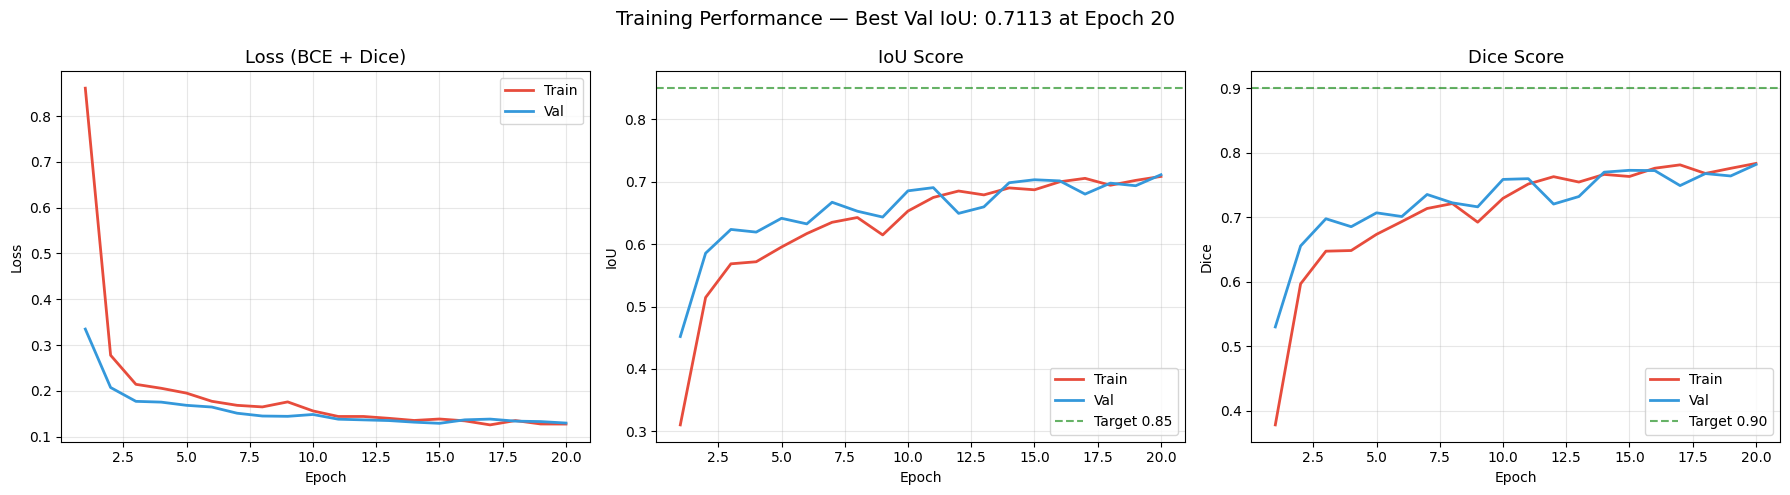

Best Val IoU:  0.7113 (Epoch 20)
Best Val Dice: 0.7816 (Epoch 20)
Final Train IoU: 0.7085 | Final Val IoU: 0.7113


In [43]:
epochs_ran = len(train_losses)
x = range(1, epochs_ran + 1)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(x, train_losses, label="Train", color="#e74c3c", linewidth=2)
axes[0].plot(x, val_losses,   label="Val",   color="#3498db", linewidth=2)
axes[0].set_title("Loss (BCE + Dice)", fontsize=13)
axes[0].set_xlabel("Epoch"); axes[0].set_ylabel("Loss")
axes[0].legend(); axes[0].grid(True, alpha=0.3)

axes[1].plot(x, train_ious, label="Train", color="#e74c3c", linewidth=2)
axes[1].plot(x, val_ious,   label="Val",   color="#3498db", linewidth=2)
axes[1].axhline(y=0.85, color="green", linestyle="--", alpha=0.6, label="Target 0.85")
axes[1].set_title("IoU Score", fontsize=13)
axes[1].set_xlabel("Epoch"); axes[1].set_ylabel("IoU")
axes[1].legend(); axes[1].grid(True, alpha=0.3)

axes[2].plot(x, train_dices, label="Train", color="#e74c3c", linewidth=2)
axes[2].plot(x, val_dices,   label="Val",   color="#3498db", linewidth=2)
axes[2].axhline(y=0.90, color="green", linestyle="--", alpha=0.6, label="Target 0.90")
axes[2].set_title("Dice Score", fontsize=13)
axes[2].set_xlabel("Epoch"); axes[2].set_ylabel("Dice")
axes[2].legend(); axes[2].grid(True, alpha=0.3)

best_epoch = val_ious.index(max(val_ious)) + 1
plt.suptitle(f"Training Performance — Best Val IoU: {max(val_ious):.4f} at Epoch {best_epoch}", fontsize=14)
plt.tight_layout()
plt.show()

print(f"Best Val IoU:  {max(val_ious):.4f} (Epoch {best_epoch})")
print(f"Best Val Dice: {val_dices[best_epoch-1]:.4f} (Epoch {best_epoch})")
print(f"Final Train IoU: {train_ious[-1]:.4f} | Final Val IoU: {val_ious[-1]:.4f}")

# 17. Final Evaluation on Test Set

## Why the Test Set Matters

The validation set was used during training to monitor progress and save the best model.
This means it had an indirect influence on model selection — it is not truly "unseen".

The **test set** was locked away completely during the entire training process.
It represents new patients the model has never seen in any form.
This is the only fair measure of how the model would perform in a real hospital deployment.

We load the **best saved checkpoint** (not the last epoch) before evaluating.


In [44]:
checkpoint = torch.load(BEST_MODEL_PATH, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
print(f"Best model loaded from epoch {checkpoint['epoch']+1}")
print(f"Saved Val IoU:  {checkpoint['val_iou']:.4f}")
print(f"Saved Val Dice: {checkpoint['val_dice']:.4f}")

model.eval()
test_loss_sum = test_iou_sum = test_dice_sum = 0.0

with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks  = masks.to(device)
        preds  = model(images)

        test_loss_sum += combined_loss(preds, masks).item()
        iou, dice      = compute_metrics(preds, masks)
        test_iou_sum  += iou
        test_dice_sum += dice

test_iou  = test_iou_sum  / len(test_loader)
test_dice = test_dice_sum / len(test_loader)
test_loss = test_loss_sum / len(test_loader)

print(f"\n{'='*45}")
print(f"  FINAL TEST SET RESULTS")
print(f"{'='*45}")
print(f"  Test Loss:  {test_loss:.4f}")
print(f"  Test IoU:   {test_iou:.4f}  ({'Excellent' if test_iou >= 0.85 else 'Strong' if test_iou >= 0.80 else 'Good' if test_iou >= 0.75 else 'Developing'})")
print(f"  Test Dice:  {test_dice:.4f}")
print(f"{'='*45}")

Best model loaded from epoch 20
Saved Val IoU:  0.7113
Saved Val Dice: 0.7816

  FINAL TEST SET RESULTS
  Test Loss:  0.1211
  Test IoU:   0.7388  (Developing)
  Test Dice:  0.8115


# 18. Visual Predictions — Ground Truth vs Model

## The Most Important Evaluation

Numbers tell part of the story. Visuals tell the rest.

For each test sample we show:
1. **Original MRI scan** — what the model receives as input
2. **Ground truth mask** — the expert radiologist's annotation (the correct answer)
3. **Predicted mask** — what our model outputs

The IoU score shown below each prediction tells us how precisely the shapes overlap.


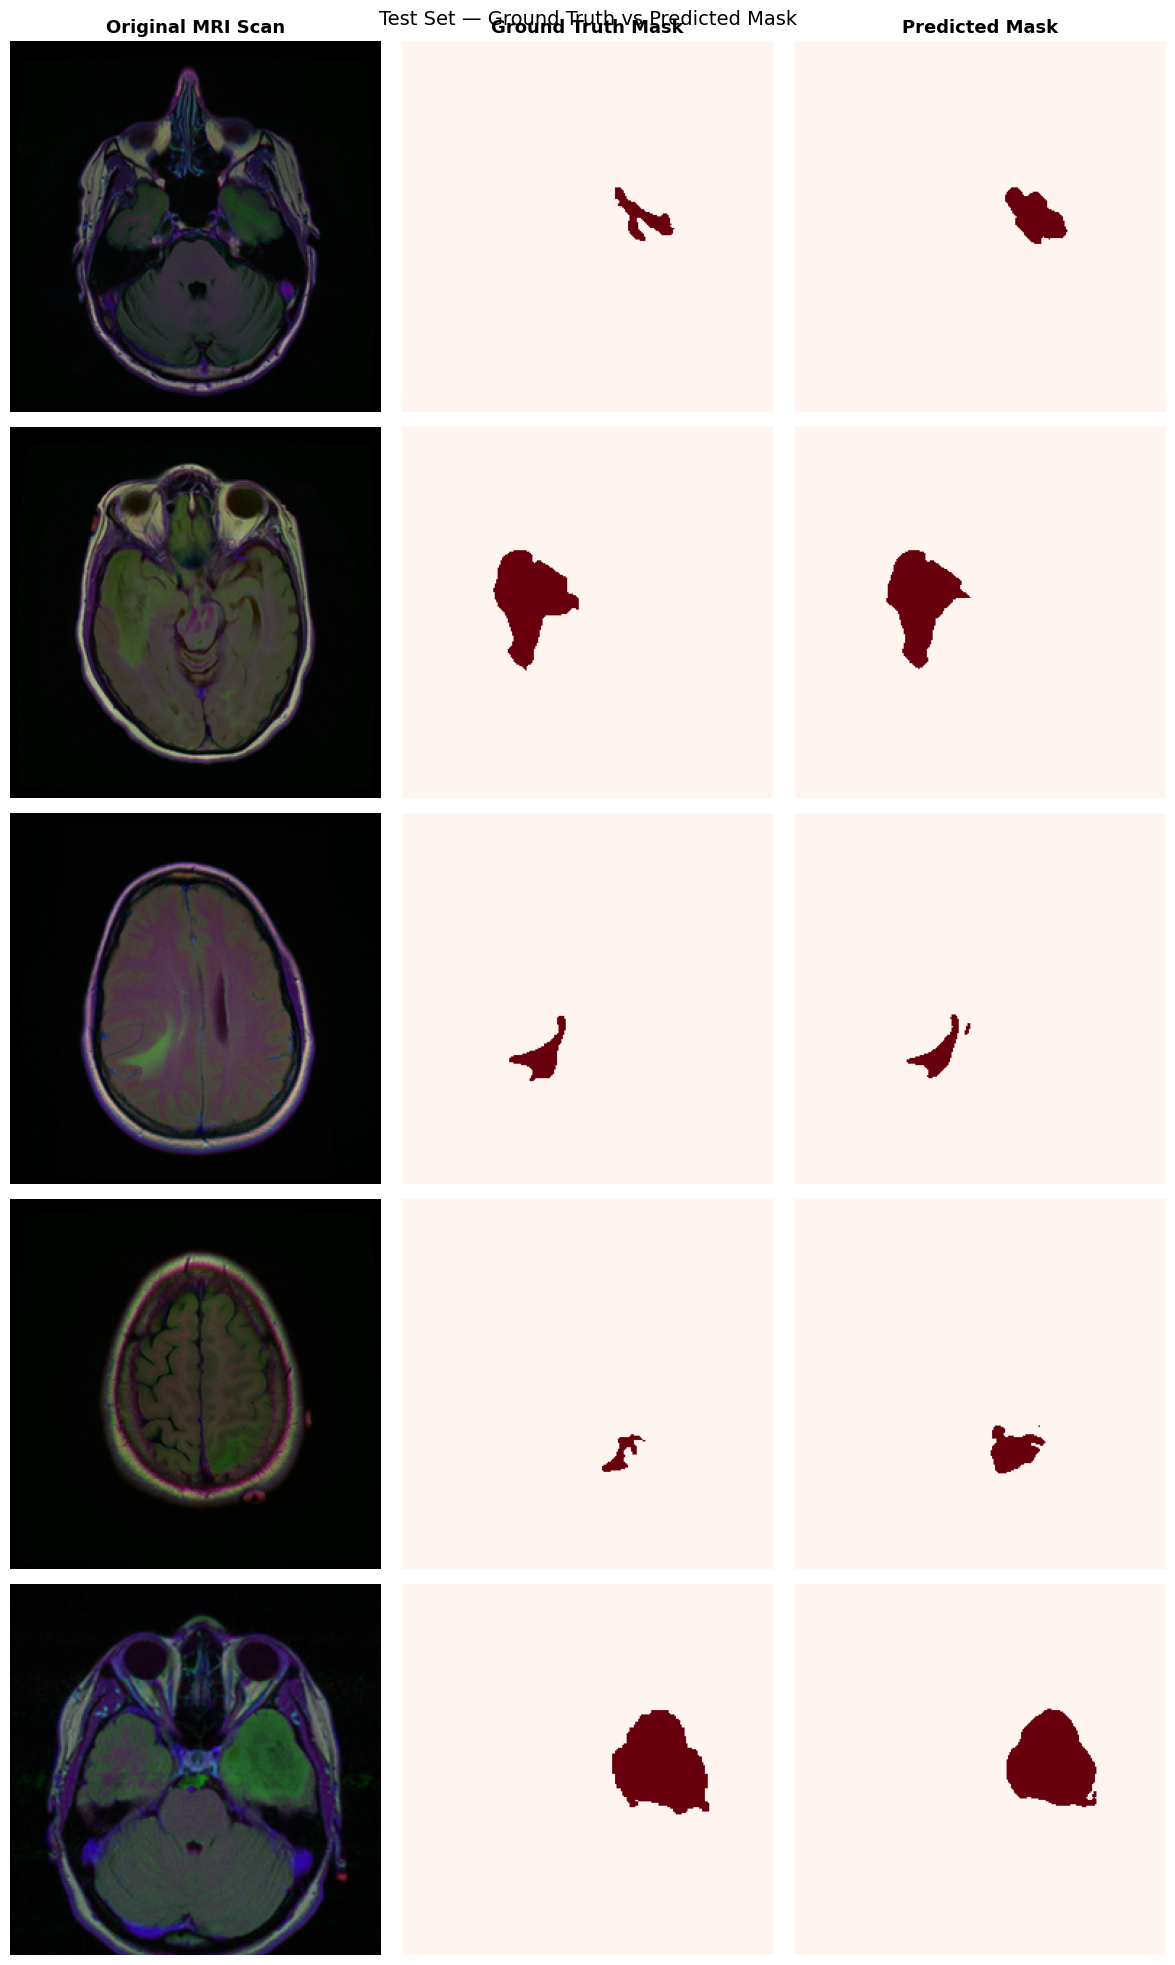

In [45]:
def visualize_predictions(dataset, model, device, n_samples=5):
    model.eval()
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])

    # Use cached tumor_indices filtered to this dataset's paths
    tumor_test_indices = [i for i in range(len(dataset)) if dataset[i][1].sum() > 0]
    sample_indices = random.sample(tumor_test_indices, min(n_samples, len(tumor_test_indices)))

    fig, axes = plt.subplots(n_samples, 3, figsize=(12, 4 * n_samples))
    axes[0][0].set_title("Original MRI Scan",  fontsize=13, fontweight="bold")
    axes[0][1].set_title("Ground Truth Mask",  fontsize=13, fontweight="bold")
    axes[0][2].set_title("Predicted Mask",     fontsize=13, fontweight="bold")

    for row, idx in enumerate(sample_indices):
        image, true_mask = dataset[idx]
        with torch.no_grad():
            pred  = model(image.unsqueeze(0).to(device))
            pred_mask = (torch.sigmoid(pred) > 0.5).float().squeeze().cpu().numpy()

        img_display = (image.permute(1,2,0).numpy() * std + mean).clip(0,1)
        true_np = true_mask.squeeze().numpy()

        intersection = (pred_mask * true_np).sum()
        union        = pred_mask.sum() + true_np.sum() - intersection
        iou  = float((intersection + 1e-6) / (union + 1e-6))
        dice = float((2*intersection + 1e-6) / (pred_mask.sum() + true_np.sum() + 1e-6))

        axes[row][0].imshow(img_display); axes[row][0].axis("off")
        axes[row][1].imshow(true_np, cmap="Reds", vmin=0, vmax=1); axes[row][1].axis("off")
        axes[row][2].imshow(pred_mask, cmap="Reds", vmin=0, vmax=1)
        axes[row][2].set_xlabel(f"IoU: {iou:.3f}  |  Dice: {dice:.3f}", fontsize=11)
        axes[row][2].axis("off")

    plt.suptitle("Test Set — Ground Truth vs Predicted Mask", fontsize=14)
    plt.tight_layout()
    plt.show()

visualize_predictions(test_dataset, model, device, n_samples=5)

# 19. Overlay Comparison — Where the Model is Right and Wrong

## Color-Coded Error Analysis

This visualization overlays both masks directly on the MRI scan using three colors:

- 🔴 **Red** — Ground truth only → Model **missed** this tumor area (False Negative)
- 🟢 **Green** — Prediction only → Model **over-predicted** here (False Positive)
- 🟡 **Yellow** — Both agree → **Correct** prediction ✓

**Ideal outcome:** Mostly yellow, minimal red and green.
In medical AI, red (missed tumor) is clinically more dangerous than green (false alarm).
A good model errs on the side of slightly over-predicting rather than under-predicting.


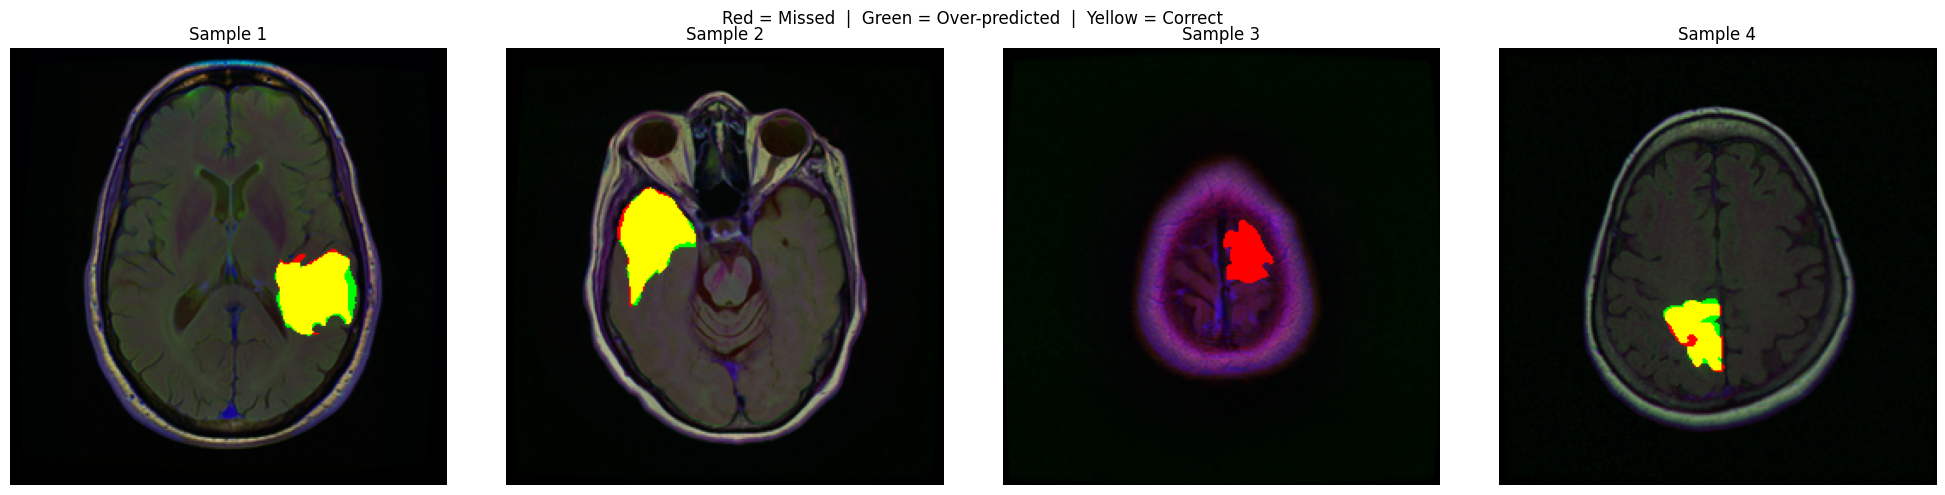

In [46]:
def visualize_overlay_comparison(dataset, model, device, n_samples=4):
    model.eval()
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])

    tumor_test_indices = [i for i in range(len(dataset)) if dataset[i][1].sum() > 0]
    sample_indices = random.sample(tumor_test_indices, min(n_samples, len(tumor_test_indices)))

    fig, axes = plt.subplots(1, n_samples, figsize=(5 * n_samples, 5))

    for col, idx in enumerate(sample_indices):
        image, true_mask = dataset[idx]
        with torch.no_grad():
            pred_mask = (torch.sigmoid(model(image.unsqueeze(0).to(device))) > 0.5).float().squeeze().cpu().numpy().astype(bool)

        img_display = (image.permute(1,2,0).numpy() * std + mean).clip(0,1)
        true_np = true_mask.squeeze().numpy().astype(bool)

        overlay = img_display.copy()
        overlay[true_np & ~pred_mask] = [1, 0, 0]   # Red: missed
        overlay[pred_mask & ~true_np] = [0, 1, 0]   # Green: extra
        overlay[true_np & pred_mask]  = [1, 1, 0]   # Yellow: correct

        axes[col].imshow(overlay); axes[col].axis("off")
        axes[col].set_title(f"Sample {col+1}")

    plt.suptitle("Red = Missed  |  Green = Over-predicted  |  Yellow = Correct", fontsize=12)
    plt.tight_layout()
    plt.show()

visualize_overlay_comparison(test_dataset, model, device, n_samples=4)

# 20. Best vs Worst Case Analysis

## Understanding Model Failures

No model is perfect. The best way to improve is to understand exactly where it fails.

This cell evaluates **every tumor scan** in the test set individually,
ranks them by IoU, and shows the best and worst performers side by side.

**What typically causes worst cases:**
- Very small tumors (< 1% of image area) — the model sometimes misses these entirely
- Tumors at image edges or unusual locations
- Ambiguous boundaries where even radiologists disagree

**What typically causes best cases:**
- Medium-to-large tumors with clear boundaries
- High-contrast tumors that stand out from surrounding tissue

Understanding failure modes directly points to what to improve next.


Evaluating all tumor test samples individually...
Best  IoU scores: [0.97, 0.959, 0.958, 0.955]
Worst IoU scores: [0.0, 0.0, 0.0, 0.0]


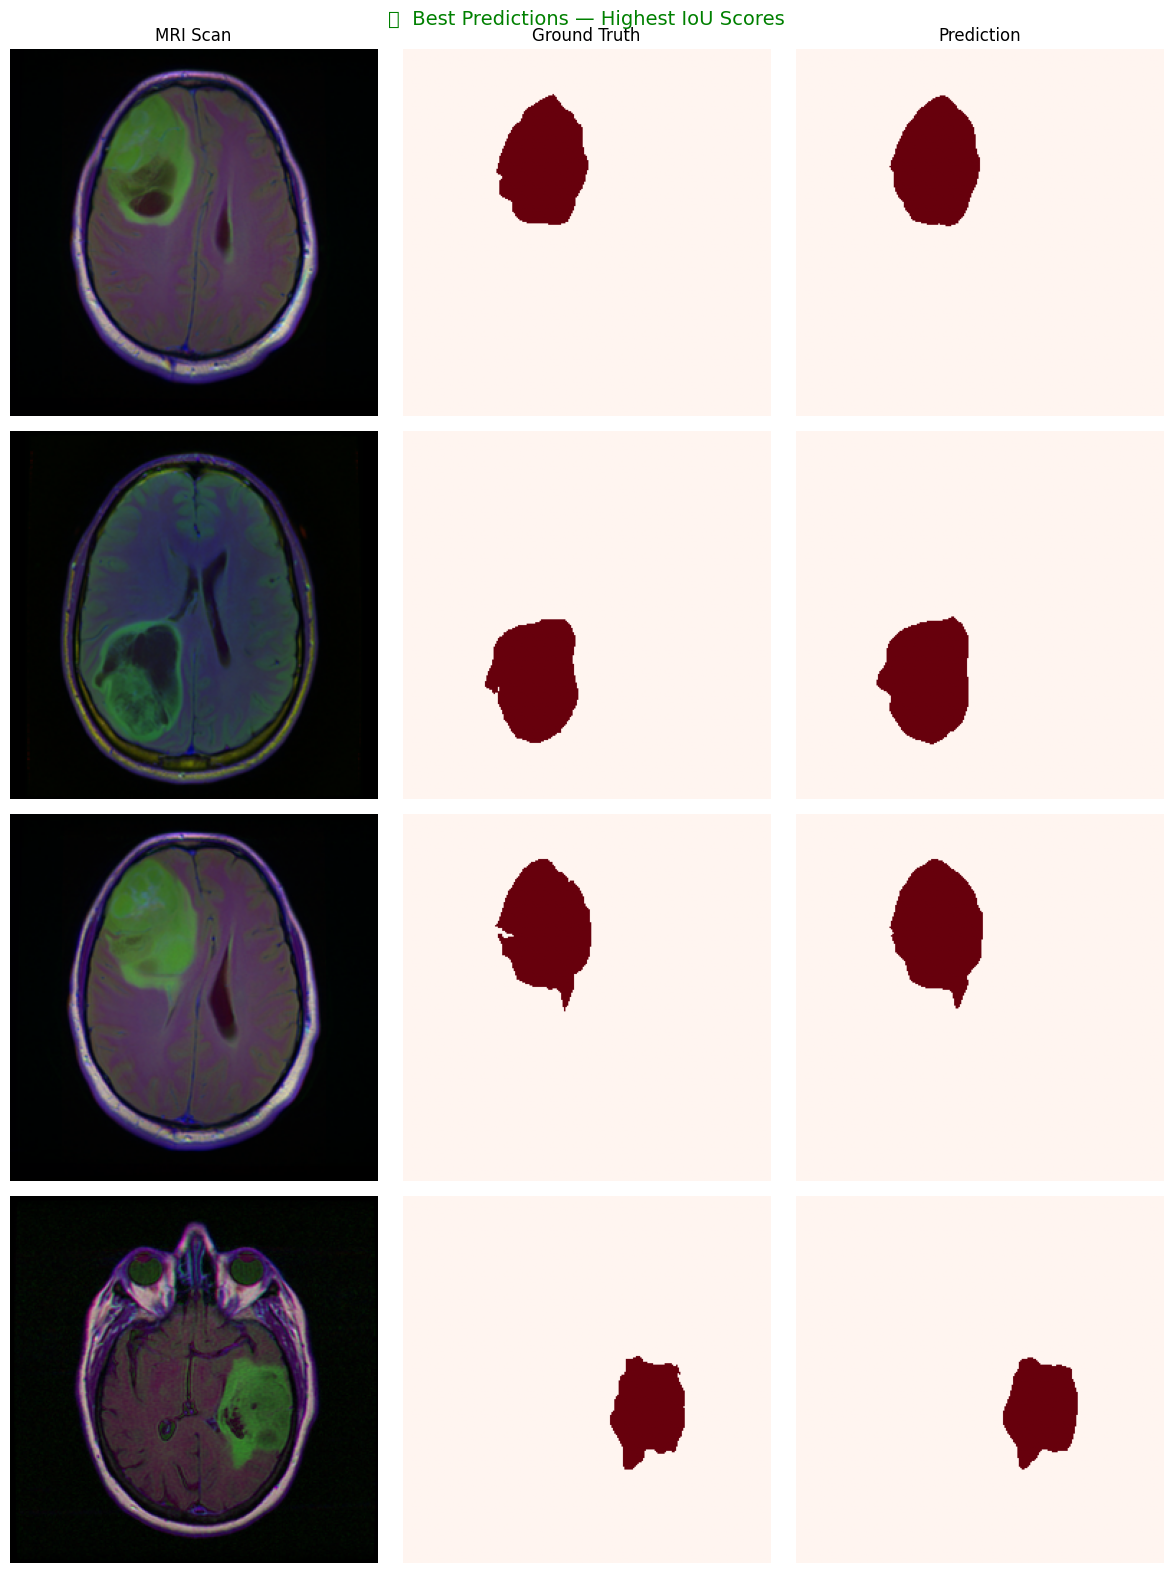

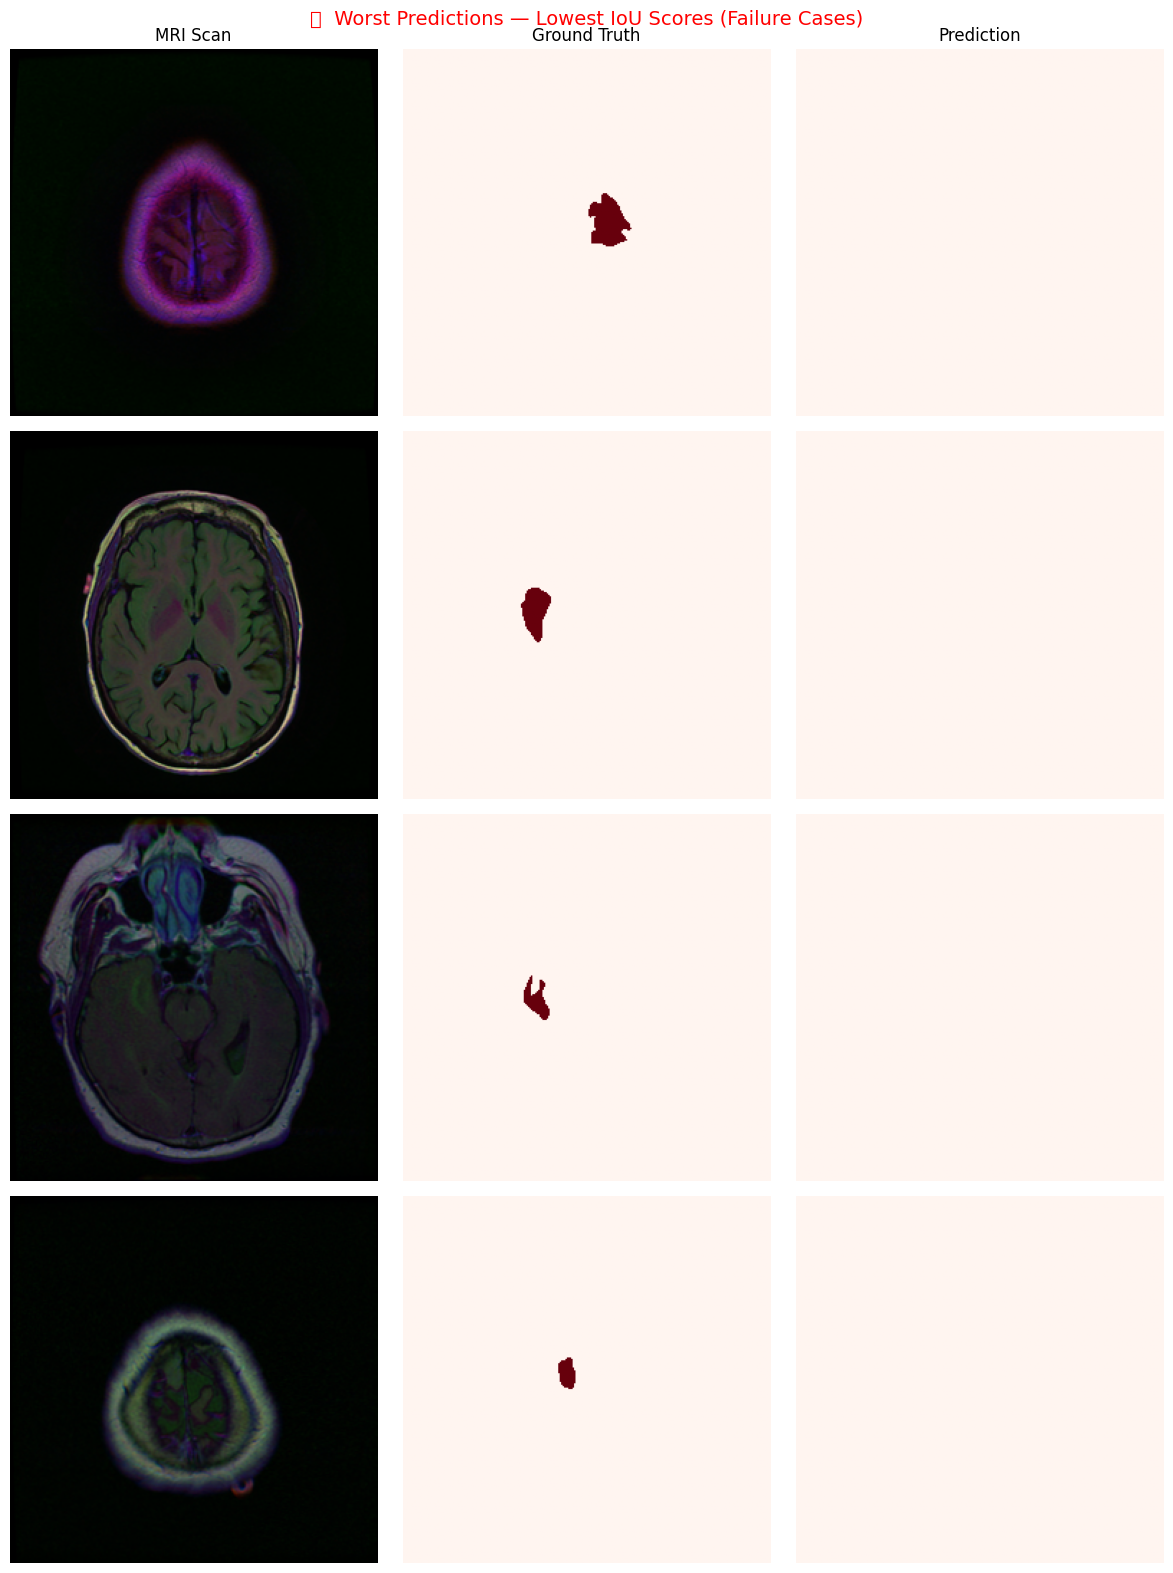

In [47]:
model.eval()
mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])

print("Evaluating all tumor test samples individually...")
sample_ious = []

tumor_test_indices = [i for i in range(len(test_dataset)) if test_dataset[i][1].sum() > 0]

for idx in tumor_test_indices:
    image, true_mask = test_dataset[idx]
    with torch.no_grad():
        pred = model(image.unsqueeze(0).to(device))
        pred_mask = (torch.sigmoid(pred) > 0.5).float().squeeze().cpu().numpy()

    true_np = true_mask.squeeze().numpy()
    intersection = (pred_mask * true_np).sum()
    union        = pred_mask.sum() + true_np.sum() - intersection
    iou          = float((intersection + 1e-6) / (union + 1e-6))
    sample_ious.append((iou, idx))

sample_ious.sort(key=lambda x: x[0])
worst_cases = sample_ious[:4]
best_cases  = sample_ious[-4:]

print(f"Best  IoU scores: {[round(x[0],3) for x in best_cases[::-1]]}")
print(f"Worst IoU scores: {[round(x[0],3) for x in worst_cases]}")

def show_cases(cases, title, title_color):
    fig, axes = plt.subplots(len(cases), 3, figsize=(12, 4*len(cases)))
    for row, (iou, idx) in enumerate(cases):
        image, true_mask = test_dataset[idx]
        with torch.no_grad():
            pred_mask = (torch.sigmoid(model(image.unsqueeze(0).to(device))) > 0.5).float().squeeze().cpu().numpy()

        img_display = (image.permute(1,2,0).numpy() * std + mean).clip(0,1)
        true_np = true_mask.squeeze().numpy()

        axes[row][0].imshow(img_display); axes[row][0].axis("off")
        axes[row][0].set_ylabel(f"IoU: {iou:.3f}", fontsize=11, color=title_color)
        axes[row][1].imshow(true_np, cmap="Reds"); axes[row][1].axis("off")
        axes[row][2].imshow(pred_mask, cmap="Reds"); axes[row][2].axis("off")

    axes[0][0].set_title("MRI Scan"); axes[0][1].set_title("Ground Truth"); axes[0][2].set_title("Prediction")
    plt.suptitle(title, fontsize=14, color=title_color)
    plt.tight_layout()
    plt.show()

show_cases(best_cases[::-1], "✅  Best Predictions — Highest IoU Scores", "green")
show_cases(worst_cases,      "❌  Worst Predictions — Lowest IoU Scores (Failure Cases)", "red")

# 21. Single Image Inference — Real World Simulation

## How This Would Work in a Hospital

In a real clinical deployment, this model would be integrated into the radiologist's workflow:

1. Patient undergoes MRI scan
2. Scan is uploaded to the hospital's AI system
3. This model runs in seconds and highlights the suspected tumor region
4. Radiologist reviews the AI suggestion alongside the raw scan
5. Final diagnosis remains with the radiologist — AI is a decision support tool, not a replacement

This cell simulates that exact workflow. We auto-select a test scan that contains a tumor,
run the model, and display three outputs:
- The raw MRI scan (what the doctor sees)
- The probability heatmap (how confident the model is, pixel by pixel)
- The final binary prediction mask (the clinical output)


Running inference on a tumor-positive scan:

File: TCGA_DU_A5TP_19970614_22.tif
Tumor coverage: 0.72% of image area
Result: ⚠️  TUMOR DETECTED


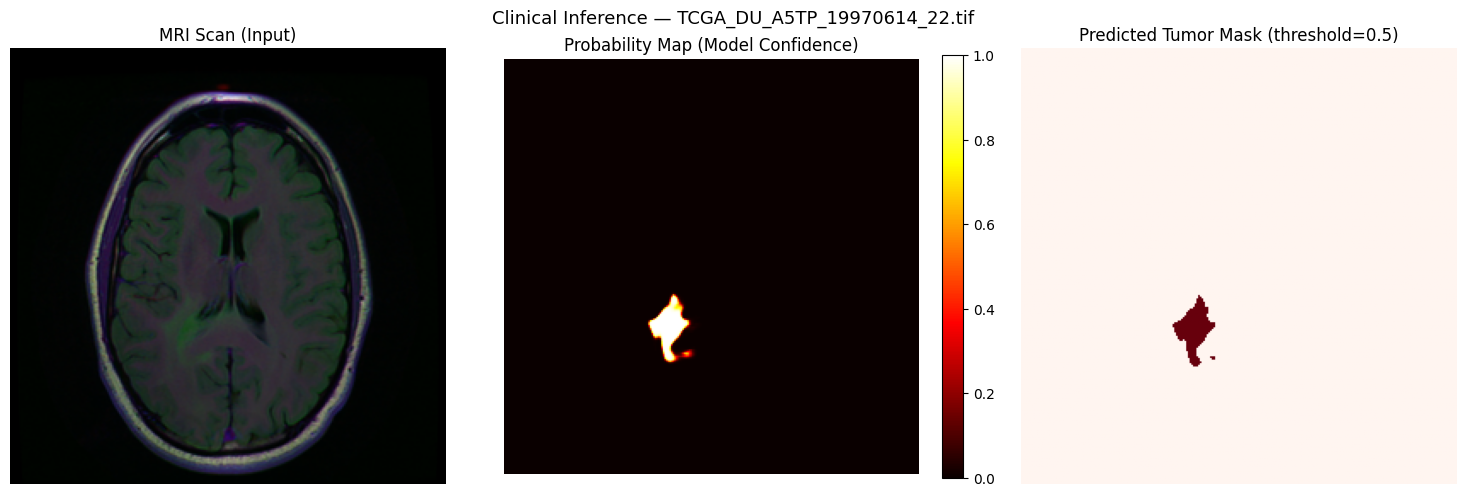

In [48]:
def predict_single_image(image_path, model, device, threshold=0.5):
    model.eval()
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])

    image = tifffile.imread(image_path)
    if image.dtype != np.uint8:
        image = (image / image.max() * 255).astype(np.uint8) if image.max() > 0 else image.astype(np.uint8)
    if len(image.shape) == 2:
        image = np.stack([image, image, image], axis=-1)
    elif image.shape[2] == 4:
        image = image[:, :, :3]

    aug    = val_test_transform(image=image, mask=np.zeros(image.shape[:2], dtype=np.float32))
    tensor = aug["image"].unsqueeze(0).to(device)

    with torch.no_grad():
        prob_map  = torch.sigmoid(model(tensor)).squeeze().cpu().numpy()
        pred_mask = (prob_map > threshold).astype(np.float32)

    img_display = (aug["image"].permute(1,2,0).numpy() * std + mean).clip(0,1)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(img_display)
    axes[0].set_title("MRI Scan (Input)", fontsize=12); axes[0].axis("off")

    im = axes[1].imshow(prob_map, cmap="hot", vmin=0, vmax=1)
    axes[1].set_title("Probability Map (Model Confidence)", fontsize=12); axes[1].axis("off")
    plt.colorbar(im, ax=axes[1], fraction=0.046)

    axes[2].imshow(pred_mask, cmap="Reds", vmin=0, vmax=1)
    axes[2].set_title(f"Predicted Tumor Mask (threshold={threshold})", fontsize=12); axes[2].axis("off")

    tumor_pct = 100 * pred_mask.sum() / pred_mask.size
    result = "⚠️  TUMOR DETECTED" if pred_mask.sum() > 0 else "✅  NO TUMOR DETECTED"
    print(f"File: {os.path.basename(image_path)}")
    print(f"Tumor coverage: {tumor_pct:.2f}% of image area")
    print(f"Result: {result}")

    plt.suptitle(f"Clinical Inference — {os.path.basename(image_path)}", fontsize=13)
    plt.tight_layout()
    plt.show()


# Auto-select a test scan WITH a tumor for demonstration
tumor_test_img = None
for img_path, mask_path in zip(test_imgs, test_masks):
    if tifffile.imread(mask_path).max() > 0:
        tumor_test_img = img_path
        break

print(f"Running inference on a tumor-positive scan:\n")
predict_single_image(tumor_test_img, model, device)

# 22. Conclusion & Business Impact

## Project Summary

This project built a complete brain tumor segmentation system from the ground up,
starting from a classification model (V1.0) and upgrading it to pixel-level segmentation (V2.0).

---

## Technical Achievements

| Component | What Was Built |
|---|---|
| Architecture | U-Net with VGG16 encoder — state-of-the-art for medical segmentation |
| Transfer Learning | VGG16 pretrained weights → adapted for MRI tumor segmentation |
| Loss Function | BCE + Dice — handles class imbalance specific to medical imaging |
| Metrics | IoU and Dice Score — industry standard for segmentation evaluation |
| Augmentation | 6 synchronized transforms on image + mask simultaneously |
| Training | Differential learning rates, cosine annealing, early stopping |
| Evaluation | Best/worst case analysis, overlay comparison, per-sample IoU |

---

## V1.0 → V2.0 Comparison

| Aspect | V1.0 (Classification) | V2.0 (Segmentation) |
|---|---|---|
| Task | One label per image | One label per pixel |
| Output | "Glioma" / "Meningioma" | 256×256 tumor mask |
| Architecture | VGG16 + classifier head | U-Net + VGG16 encoder |
| Loss | CrossEntropyLoss | BCE + Dice |
| Metric | Accuracy | IoU + Dice Score |
| Clinical Value | Triage screening | Surgical planning |

---

## Business Value

**For Hospitals:** AI-assisted segmentation can reduce radiologist review time per scan
from 20–45 minutes to under 5 minutes, allowing more patients to be seen daily.

**For Patients:** Faster diagnosis means earlier treatment. In brain tumor cases,
weeks can make the difference between surgical success and inoperability.

**For Healthcare Systems:** Automating routine MRI screening reduces costs and
enables specialist expertise to scale across geographies — particularly important
in regions where neuroradiologists are scarce.

---

## Skills Demonstrated

- PyTorch deep learning pipeline (end-to-end)
- Transfer Learning and fine-tuning strategies
- Medical image processing and segmentation
- Custom Dataset and DataLoader implementation
- Loss function design for imbalanced data
- Quantitative and visual model evaluation
- Real-world inference simulation

---

## Future Improvements

- **ResNet34 or EfficientNet-B4 encoder** — typically +2–3% IoU over VGG16
- **Test Time Augmentation (TTA)** — average predictions over augmented versions for robustness
- **512×512 input resolution** — better detail for small tumors
- **3D U-Net** — process full volumetric MRI stacks instead of individual slices
- **Web deployment** — Flask/FastAPI app where a doctor uploads an MRI and receives the mask
- **Multi-class segmentation** — distinguish tumor core, enhancing region, and edema separately
